In [189]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from sklearn import preprocessing

import datetime
import time

from torch import nn, tensor, optim
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import torch.nn.functional as F
import torch

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, ConvLSTM2D, BatchNormalization, Dense, MaxPool3D, \
TimeDistributed, Flatten, Reshape

In [334]:
start = datetime.datetime(2014, 9, 20)
end = datetime.datetime(2021, 5, 20)

In [335]:
data = pdr.get_data_yahoo(['BTC-USD'], start=start, end=end)
data.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2014-09-19,408.903992,408.903992,423.295990,389.882996,394.673004,36863600.0
2014-09-20,398.821014,398.821014,412.425995,393.181000,408.084991,26580100.0
2014-09-21,402.152008,402.152008,406.915985,397.130005,399.100006,24127600.0
2014-09-22,435.790985,435.790985,441.557007,396.196991,402.092010,45099500.0
2014-09-23,423.204987,423.204987,436.112000,421.131989,435.751007,30627700.0


In [336]:
normalizer = preprocessing.MinMaxScaler()
col_names = data.columns
data = normalizer.fit_transform(data)
data = pd.DataFrame(data, columns=col_names)

In [337]:
data.shape

(2432, 6)

In [338]:
test_length = 100
valid_length = 40
length = len(data) - test_length - valid_length

start = np.random.randint(0, length)
test = data.iloc[start:start+test_length]
valid = data.iloc[(start+test_length):(start+test_length+valid_length)]
train = data.drop(data.index[[i for i in range(start,start+test_length+valid_length)]])

In [195]:
# test_length = 200
# valid_length = 40

# test = data.iloc[-test_length:]
# valid = data.iloc[-test_length-valid_length:-test_length]
# train = data.iloc[:-test_length-valid_length]

In [196]:
print(test.shape, train.shape, valid.shape)

(100, 6) (2292, 6) (40, 6)


In [197]:
seq_len = 24
def generate_x_y(data, start=None, test_length=None):
    
    x, y = [], []
    train = (start != None)
    for i in range(len(data)-seq_len):
        if train:
            if not (start - seq_len <=  i <= start+test_length):
                x.append(data.iloc[i:i+seq_len][['Close', 'High', 'Low', 'Open', 'Volume']].values)
                y.append(data.iloc[i+seq_len]['Close'].values)
        else:
            x.append(data.iloc[i:i+seq_len][['Close', 'High', 'Low', 'Open', 'Volume']].values)
            y.append(data.iloc[i+seq_len]['Close'].values)
        
    # return np.array(x), np.array(y)
    return tensor(x), tensor(y)
# for using pytorch, change numpy arrays to tensor

In [198]:
x_train, y_train = generate_x_y(train, start=start, test_length=test_length+valid_length)
x_test, y_test = generate_x_y(test)
x_valid, y_valid = generate_x_y(valid)

In [199]:
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

torch.Size([2103, 24, 5])
torch.Size([76, 24, 5])
torch.Size([16, 24, 5])


In [200]:
def generate_batches(x, y, batch_size=128):
    
    indices = [i for i in range(len(x))]
    
    start = 0
    while start+batch_size <= len(x):
        batch_indices = indices[start:start+batch_size]
        yield tensor(x[batch_indices]).float(), tensor(y[batch_indices]).float()
        start += batch_size
        
    if start < len(x):
        yield tensor(x[start:]).float(), tensor(y[start:]).float()

In [270]:
class WolfLSTM(nn.Module):
    
    def __init__(self, hidden_dim, n_lsmt_layers, input_dim, output_dim, linear_dim, cell_type=nn.LSTM, model_name = 'LSTM'):
        
        super(WolfLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_lsmt_layers
        self.model_name = model_name
        self.lstm = cell_type(input_dim, hidden_dim, n_lsmt_layers, batch_first=True)
        self.output = nn.Linear(hidden_dim*seq_len, output_dim)
        
    def forward(self, sequence, hidden, seq_lens=None, eval_=False):
        
        lstm_out, hidden = self.lstm(sequence, hidden)
        
        lstm_out = lstm_out.reshape(sequence.shape[0], -1)
        output = self.output(lstm_out)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        if self.model_name == 'LSTM':

          weight = next(self.parameters()).data
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
          hidden = tuple([h.data for h in hidden])
        else:
          weight = next(self.parameters()).data
          hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()

        return hidden

In [271]:
def train(
    model, x_train, y_train, x_valid, y_valid, loss_func, opti, batch_size=128, epochs=100
    ):
        
    losses, valid_losses = [], []
    batch_loss = None

    loss, opt = loss_func, opti

    model.train()
    for epoch in range(epochs):
        
        print(f'============================== epoch {epoch}, loss {batch_loss}')
        start = time.time()

        epoch_loss = []
        for x_batch, y_batch in generate_batches(x_train, y_train, batch_size):

            hidden = model.init_hidden(len(x_batch))
            
            
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

            model.zero_grad()

            y_pred, hidden = model(x_batch, hidden)
            y_pred = y_pred.cpu()
            y_batch = y_batch.cpu()
            batch_loss = loss(y_pred, y_batch.view(-1))
            batch_loss.backward()
            opt.step()

            epoch_loss.append(batch_loss.detach().numpy())

        losses.append(np.mean(epoch_loss))

        with torch.no_grad():
            
            hidden = model.init_hidden(len(x_valid))
            
            x_valid = tensor(x_valid).float().cuda()
            y_valid = tensor(y_valid).float().cuda()

            y_pred, hidden = model(x_valid, hidden)
            y_pred = y_pred.cpu()
            y_valid = y_valid.cpu()
            batch_loss = loss(y_pred, y_valid.view(-1))

            valid_losses.append(batch_loss.detach().numpy())

        print(f'passed time: {time.time() - start}')
        
    return losses, valid_losses

In [203]:
def predict(model, x_test):
    
    model.eval()

    hidden = model.init_hidden(len(x_test))
    x_test = tensor(x_test).float().cuda()
    predicted, hidden = model(x_test, hidden, eval_=True)

    return predicted.detach().cpu().numpy()

In [204]:
%%time
lstm = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.LSTM, model_name='LSTM').cuda()
loss = nn.MSELoss() 
opt = optim.Adam(lstm.parameters(), lr=0.0001)

losses, valid_losses = train(lstm, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.08930444717407227
============================== epoch 1, loss 0.00789019837975502
passed time: 0.08982539176940918
============================== epoch 2, loss 0.00377662293612957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.08687138557434082
============================== epoch 3, loss 0.002787664532661438
passed time: 0.08005309104919434
============================== epoch 4, loss 0.0024830044712871313
passed time: 0.0807187557220459
============================== epoch 5, loss 0.002456158399581909
passed time: 0.08451294898986816
============================== epoch 6, loss 0.0024185641668736935
passed time: 0.07720279693603516
============================== epoch 7, loss 0.0021482957527041435
passed time: 0.0812540054321289
============================== epoch 8, loss 0.0021561644971370697
passed time: 0.08009886741638184
============================== epoch 9, loss 0.001996707171201706
passed time: 0.07595229148864746
============================== epoch 10, loss 0.0020230202935636044
passed time: 0.07743215560913086
============================== epoch 11, loss 0.0018157499143853784
passed time: 0.07763195037841797
============================== epoch 12, loss 0.0017274388810619712
pa

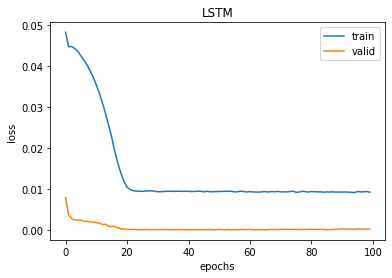

In [205]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LSTM')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


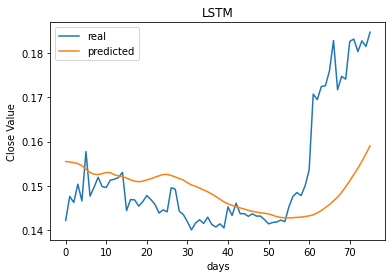

In [206]:
predicted = predict(lstm, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('LSTM')
plt.legend()

In [207]:
%%time
gru = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.GRU, model_name='GRU').cuda()
loss = nn.MSELoss() 
opt = optim.Adam(gru.parameters(), lr=0.0001)

losses, valid_losses = train(gru, x_train, y_train, x_valid, y_valid, loss, opt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


============================== epoch 0, loss None
passed time: 0.0819234848022461
============================== epoch 1, loss 0.002339051105082035
passed time: 0.06937432289123535
============================== epoch 2, loss 0.0010709173511713743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor,

passed time: 0.07468175888061523
============================== epoch 3, loss 0.0015276205958798528
passed time: 0.06981253623962402
============================== epoch 4, loss 0.0014765022788196802
passed time: 0.06850314140319824
============================== epoch 5, loss 0.0011799819767475128
passed time: 0.07247447967529297
============================== epoch 6, loss 0.001168366172350943
passed time: 0.07324361801147461
============================== epoch 7, loss 0.0007815100252628326
passed time: 0.07484793663024902
============================== epoch 8, loss 0.0004031070857308805
passed time: 0.07408881187438965
============================== epoch 9, loss 0.00019814939878415316
passed time: 0.06914854049682617
============================== epoch 10, loss 0.00030971140949986875
passed time: 0.06853532791137695
============================== epoch 11, loss 0.00017543121066410094
passed time: 0.08102774620056152
============================== epoch 12, loss 0.000148603663546

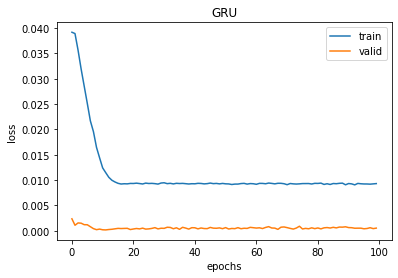

In [208]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('GRU')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


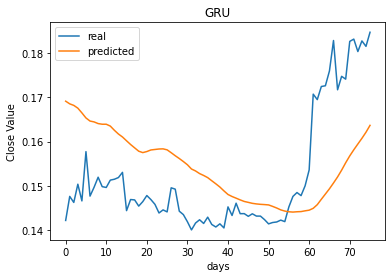

In [209]:
predicted = predict(gru, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('GRU')
plt.legend()

In [210]:
%%time
rnn = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.RNN, model_name='RNN').cuda()
loss = nn.MSELoss() 
opt = optim.Adam(rnn.parameters(), lr=0.0001)

losses, valid_losses = train(rnn, x_train, y_train, x_valid, y_valid, loss, opt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


============================== epoch 0, loss None
passed time: 0.07497715950012207
============================== epoch 1, loss 0.0008988284389488399
passed time: 0.06933951377868652
============================== epoch 2, loss 0.006488840561360121


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor,

passed time: 0.07587504386901855
============================== epoch 3, loss 0.003337502246722579
passed time: 0.07203865051269531
============================== epoch 4, loss 0.002626173198223114
passed time: 0.0723114013671875
============================== epoch 5, loss 0.0013487718533724546
passed time: 0.07208895683288574
============================== epoch 6, loss 0.002149200066924095
passed time: 0.07475423812866211
============================== epoch 7, loss 0.0007514256285503507
passed time: 0.07068443298339844
============================== epoch 8, loss 0.0010724967578426003
passed time: 0.07214665412902832
============================== epoch 9, loss 0.0018188497051596642
passed time: 0.08060216903686523
============================== epoch 10, loss 0.0008170026121661067
passed time: 0.07804989814758301
============================== epoch 11, loss 0.0015816689701750875
passed time: 0.07098937034606934
============================== epoch 12, loss 0.0009468845091760159
p

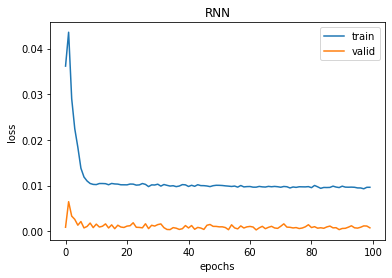

In [211]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('RNN')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


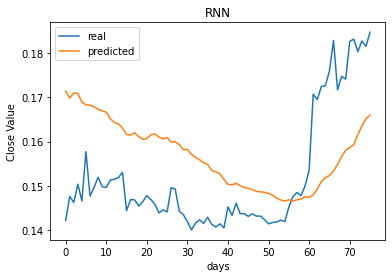

In [212]:
predicted = predict(rnn, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('RNN')
plt.legend()

In [219]:
%%time
lstm = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.LSTM, model_name='LSTM').cuda()
loss = nn.L1Loss() 
opt = optim.Adam(lstm.parameters(), lr=0.0001)

losses, valid_losses = train(lstm, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.12606477737426758
============================== epoch 1, loss 0.10311572253704071


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.

passed time: 0.13089632987976074
============================== epoch 2, loss 0.08920633047819138
passed time: 0.13711309432983398
============================== epoch 3, loss 0.09508292376995087
passed time: 0.13735103607177734
============================== epoch 4, loss 0.0946793258190155
passed time: 0.13948535919189453
============================== epoch 5, loss 0.09296576678752899
passed time: 0.1312258243560791
============================== epoch 6, loss 0.08698559552431107
passed time: 0.13030052185058594
============================== epoch 7, loss 0.08618326485157013
passed time: 0.131394624710083
============================== epoch 8, loss 0.08420993387699127
passed time: 0.12387800216674805
============================== epoch 9, loss 0.07948818057775497
passed time: 0.13414716720581055
============================== epoch 10, loss 0.07683458179235458
passed time: 0.12428593635559082
============================== epoch 11, loss 0.07091250270605087
passed time: 0.1294164

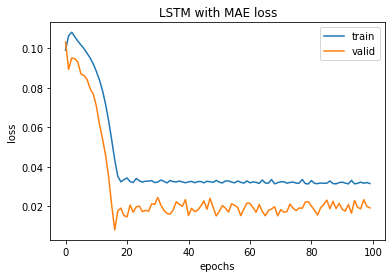

In [220]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LSTM with MAE loss')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


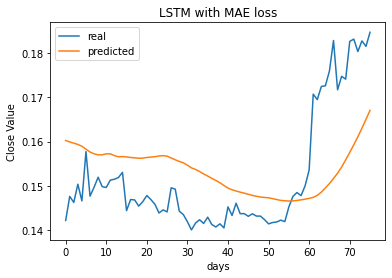

In [222]:
predicted = predict(lstm, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('LSTM with MAE loss')
plt.legend()

In [232]:
%%time
lstm = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.LSTM, model_name='LSTM').cuda()
loss = nn.MSELoss() 
opt = optim.SGD(lstm.parameters(), lr=0.001)

losses, valid_losses = train(lstm, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.0787191390991211
============================== epoch 1, loss 0.015639133751392365
passed time: 0.07451272010803223
============================== epoch 2, loss 0.011869087815284729


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.07677030563354492
============================== epoch 3, loss 0.009593235328793526
passed time: 0.06810665130615234
============================== epoch 4, loss 0.007841574028134346
passed time: 0.06907916069030762
============================== epoch 5, loss 0.00637167040258646
passed time: 0.06610488891601562
============================== epoch 6, loss 0.005158704239875078
passed time: 0.06801033020019531
============================== epoch 7, loss 0.0042832461185753345
passed time: 0.06760191917419434
============================== epoch 8, loss 0.0038328098598867655
passed time: 0.06418585777282715
============================== epoch 9, loss 0.0031417696736752987
passed time: 0.06615400314331055
============================== epoch 10, loss 0.002823953051120043
passed time: 0.06291532516479492
============================== epoch 11, loss 0.0025505446828901768
passed time: 0.06339669227600098
============================== epoch 12, loss 0.0021708430722355843
pas

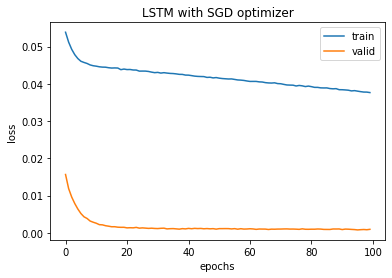

In [233]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LSTM with SGD optimizer')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


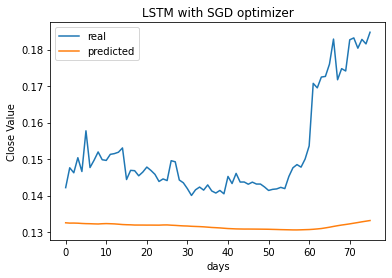

In [234]:
predicted = predict(lstm, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('LSTM with SGD optimizer')
plt.legend()

In [229]:
%%time
lstm = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.LSTM, model_name='LSTM').cuda()
loss = nn.MSELoss() 
opt = optim.Adagrad(lstm.parameters(), lr=0.001)

losses, valid_losses = train(lstm, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.10458993911743164
============================== epoch 1, loss 0.0032576927915215492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.10984992980957031
============================== epoch 2, loss 9.801124542718753e-05
passed time: 0.10692119598388672
============================== epoch 3, loss 7.496657053707168e-05
passed time: 0.11062932014465332
============================== epoch 4, loss 0.00020921439863741398
passed time: 0.10535502433776855
============================== epoch 5, loss 0.000292559212539345
passed time: 0.10370802879333496
============================== epoch 6, loss 0.00024556517018936574
passed time: 0.10473084449768066
============================== epoch 7, loss 0.0003230049042031169
passed time: 0.10387492179870605
============================== epoch 8, loss 0.0001952775928657502
passed time: 0.10352945327758789
============================== epoch 9, loss 0.00016328597848769277
passed time: 0.10622644424438477
============================== epoch 10, loss 0.0001719133579172194
passed time: 0.07001018524169922
============================== epoch 11, loss 0.0001049807979143

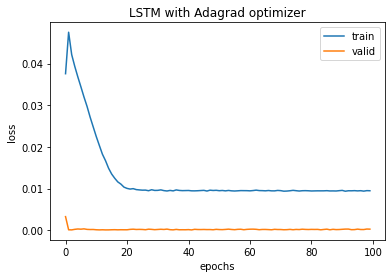

In [230]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LSTM with Adagrad optimizer')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


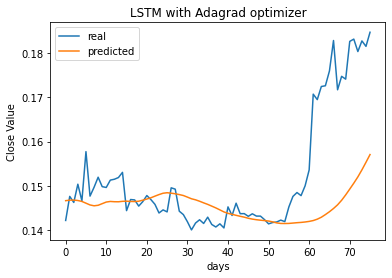

In [231]:
predicted = predict(lstm, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('LSTM with Adagrad optimizer')
plt.legend()

In [238]:
%%time
lstm = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.LSTM, model_name='LSTM').cuda()
loss = nn.MSELoss() 
opt = optim.RMSprop(lstm.parameters(), lr=0.001)

losses, valid_losses = train(lstm, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.11688828468322754
============================== epoch 1, loss 0.5438175797462463


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.14251708984375
============================== epoch 2, loss 0.05222274735569954
passed time: 0.11770939826965332
============================== epoch 3, loss 0.018863191828131676
passed time: 0.1127479076385498
============================== epoch 4, loss 0.010169458575546741
passed time: 0.11070609092712402
============================== epoch 5, loss 0.009166218340396881
passed time: 0.11774206161499023
============================== epoch 6, loss 0.011126933619379997
passed time: 0.10759472846984863
============================== epoch 7, loss 0.011546934023499489
passed time: 0.11911630630493164
============================== epoch 8, loss 0.01248745433986187
passed time: 0.11755108833312988
============================== epoch 9, loss 0.011877678334712982
passed time: 0.11679315567016602
============================== epoch 10, loss 0.013782307505607605
passed time: 0.10857939720153809
============================== epoch 11, loss 0.015018993988633156
passed time: 0

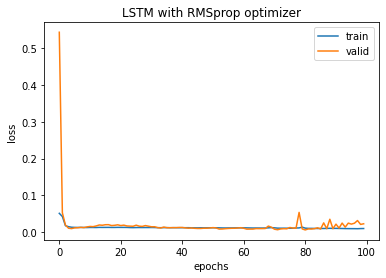

In [239]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LSTM with RMSprop optimizer')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


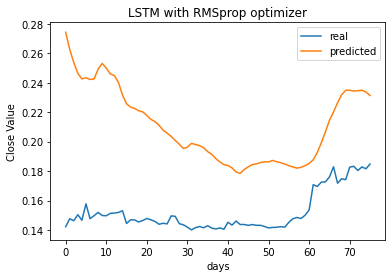

In [240]:
predicted = predict(lstm, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('LSTM with RMSprop optimizer')
plt.legend()

In [241]:
%%time
lstm = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.LSTM, model_name='LSTM').cuda()
loss = nn.MSELoss() 
opt = optim.Adagrad(lstm.parameters(), lr=0.001)

losses, valid_losses = train(lstm, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.0949714183807373
============================== epoch 1, loss 0.006765245459973812
passed time: 0.07877302169799805
============================== epoch 2, loss 0.00019831440295092762


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.07923388481140137
============================== epoch 3, loss 3.7742887798231095e-05
passed time: 0.07146239280700684
============================== epoch 4, loss 9.851291542872787e-05
passed time: 0.07433342933654785
============================== epoch 5, loss 0.0001378313172608614
passed time: 0.073089599609375
============================== epoch 6, loss 0.00021437389659695327
passed time: 0.06910395622253418
============================== epoch 7, loss 0.00015488610370084643
passed time: 0.06934452056884766
============================== epoch 8, loss 0.0002372131566517055
passed time: 0.07133150100708008
============================== epoch 9, loss 0.0001950055011548102
passed time: 0.07268166542053223
============================== epoch 10, loss 0.00023434746253769845
passed time: 0.07320642471313477
============================== epoch 11, loss 0.00013195212522987276
passed time: 0.07356476783752441
============================== epoch 12, loss 8.35192840895615

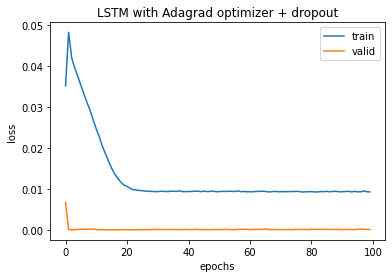

In [244]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LSTM with Adagrad optimizer + dropout')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


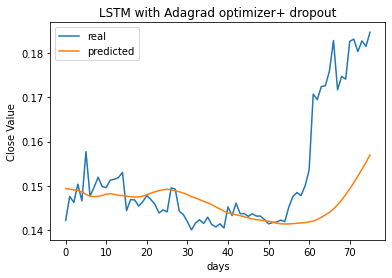

In [245]:
predicted = predict(lstm, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('LSTM with Adagrad optimizer+ dropout')
plt.legend()

In [254]:
%%time
lstm = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.LSTM, model_name='LSTM').cuda()
loss = nn.MSELoss() 
opt = optim.Adagrad(lstm.parameters(), lr=0.001)

losses, valid_losses = train(lstm, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.0720820426940918
============================== epoch 1, loss 0.005037617404013872
passed time: 0.06578850746154785
============================== epoch 2, loss 9.173302532872185e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.06878328323364258
============================== epoch 3, loss 5.690748730557971e-05
passed time: 0.06330299377441406
============================== epoch 4, loss 0.00014724723587278277
passed time: 0.06458616256713867
============================== epoch 5, loss 0.00020025044796057045
passed time: 0.06467390060424805
============================== epoch 6, loss 0.00021620746701955795
passed time: 0.06949234008789062
============================== epoch 7, loss 0.00020624556054826826
passed time: 0.06355500221252441
============================== epoch 8, loss 0.00018023047596216202
passed time: 0.06810188293457031
============================== epoch 9, loss 0.0001461953652324155
passed time: 0.06647109985351562
============================== epoch 10, loss 0.00011055648792535067
passed time: 0.06879687309265137
============================== epoch 11, loss 7.822617772035301e-05
passed time: 0.06925106048583984
============================== epoch 12, loss 5.26135663676

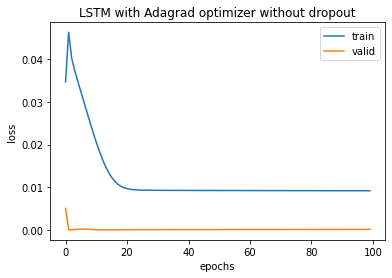

In [255]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LSTM with Adagrad optimizer without dropout')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


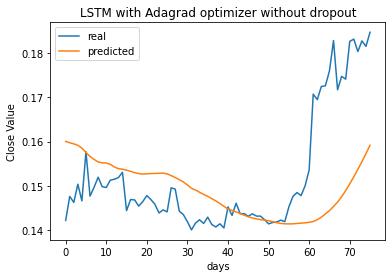

In [256]:
predicted = predict(lstm, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('LSTM with Adagrad optimizer without dropout')
plt.legend()

In [246]:
%%time
gru = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.GRU, model_name='GRU').cuda()
loss = nn.MSELoss() 
opt = optim.Adagrad(gru.parameters(), lr=0.001)

losses, valid_losses = train(gru, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.11402344703674316
============================== epoch 1, loss 0.020404061302542686


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.10191035270690918
============================== epoch 2, loss 0.0021087557543069124
passed time: 0.09939980506896973
============================== epoch 3, loss 0.0010629823664203286
passed time: 0.10380792617797852
============================== epoch 4, loss 0.0008629813673906028
passed time: 0.09393692016601562
============================== epoch 5, loss 0.0009526844369247556
passed time: 0.11324334144592285
============================== epoch 6, loss 0.0012116804718971252
passed time: 0.09729695320129395
============================== epoch 7, loss 0.0010324529139325023
passed time: 0.09691572189331055
============================== epoch 8, loss 0.000814272032584995
passed time: 0.10275840759277344
============================== epoch 9, loss 0.0006523599149659276
passed time: 0.09620547294616699
============================== epoch 10, loss 0.0010867042001336813
passed time: 0.09724211692810059
============================== epoch 11, loss 0.0005850144079886377

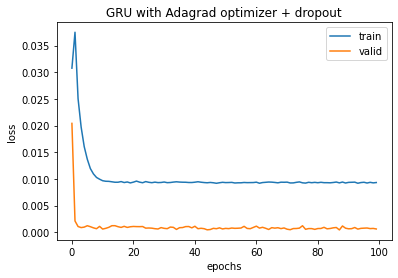

In [247]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('GRU with Adagrad optimizer + dropout')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


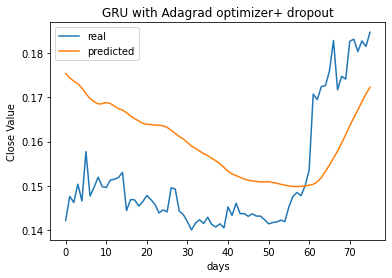

In [248]:
predicted = predict(gru, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('GRU with Adagrad optimizer+ dropout')
plt.legend()

In [257]:
%%time
gru = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.GRU, model_name='GRU').cuda()
loss = nn.MSELoss() 
opt = optim.Adagrad(gru.parameters(), lr=0.001)

losses, valid_losses = train(gru, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.06723475456237793
============================== epoch 1, loss 0.01263041328638792
passed time: 0.05902695655822754
============================== epoch 2, loss 0.000532107544131577
passed time: 0.057885169982910156
============================== epoch 3, loss 0.00016468299145344645


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.06327366828918457
============================== epoch 4, loss 0.00013086679973639548
passed time: 0.06118369102478027
============================== epoch 5, loss 0.00014709419338032603
passed time: 0.060924530029296875
============================== epoch 6, loss 0.00017771452257875353
passed time: 0.05903959274291992
============================== epoch 7, loss 0.0002094367373501882
passed time: 0.06228041648864746
============================== epoch 8, loss 0.00023514291387982666
passed time: 0.05821990966796875
============================== epoch 9, loss 0.0002524519804865122
passed time: 0.059044599533081055
============================== epoch 10, loss 0.0002622093306854367
passed time: 0.05902886390686035
============================== epoch 11, loss 0.00026656637783162296
passed time: 0.06573915481567383
============================== epoch 12, loss 0.00026762220659293234
passed time: 0.0591583251953125
============================== epoch 13, loss 0.000266903

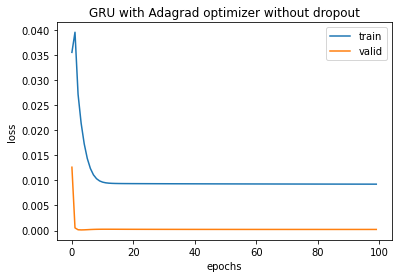

In [258]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('GRU with Adagrad optimizer without dropout')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


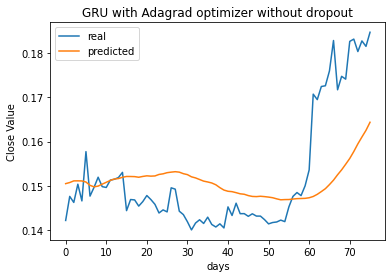

In [259]:
predicted = predict(gru, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('GRU with Adagrad optimizer without dropout')
plt.legend()

In [249]:
%%time
rnn = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.RNN, model_name='RNN').cuda()
loss = nn.MSELoss() 
opt = optim.Adagrad(rnn.parameters(), lr=0.001)

losses, valid_losses = train(rnn, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.0733342170715332
============================== epoch 1, loss 0.060557182878255844
passed time: 0.06721091270446777
============================== epoch 2, loss 0.011979889124631882


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.07591080665588379
============================== epoch 3, loss 0.005745586007833481
passed time: 0.06849455833435059
============================== epoch 4, loss 0.006760990247130394
passed time: 0.06685662269592285
============================== epoch 5, loss 0.004363978747278452
passed time: 0.07506871223449707
============================== epoch 6, loss 0.004361731931567192
passed time: 0.06860589981079102
============================== epoch 7, loss 0.004490426741540432
passed time: 0.0643622875213623
============================== epoch 8, loss 0.004305189475417137
passed time: 0.06274557113647461
============================== epoch 9, loss 0.002410302869975567
passed time: 0.0677175521850586
============================== epoch 10, loss 0.002743240911513567
passed time: 0.06379437446594238
============================== epoch 11, loss 0.0025000327732414007
passed time: 0.0666055679321289
============================== epoch 12, loss 0.0019770360086113214
passed t

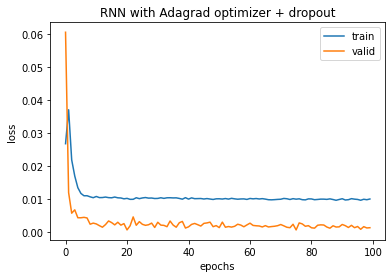

In [250]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('RNN with Adagrad optimizer + dropout')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


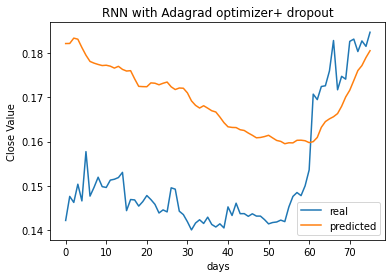

In [251]:
predicted = predict(rnn, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('RNN with Adagrad optimizer+ dropout')
plt.legend()

In [260]:
%%time
rnn = WolfLSTM(50, 2, 5, 1, 100, cell_type=nn.RNN, model_name='RNN').cuda()
loss = nn.MSELoss() 
opt = optim.Adagrad(rnn.parameters(), lr=0.001)

losses, valid_losses = train(rnn, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.06199288368225098
============================== epoch 1, loss 0.06445609033107758
passed time: 0.05772137641906738
============================== epoch 2, loss 0.013732117600739002
passed time: 0.05750560760498047
============================== epoch 3, loss 0.008490174077451229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.06582522392272949
============================== epoch 4, loss 0.006321981083601713
passed time: 0.05806159973144531
============================== epoch 5, loss 0.004861472174525261
passed time: 0.05831551551818848
============================== epoch 6, loss 0.003749793628230691
passed time: 0.05947566032409668
============================== epoch 7, loss 0.0029801311902701855
passed time: 0.06094193458557129
============================== epoch 8, loss 0.00251035881228745
passed time: 0.05828404426574707
============================== epoch 9, loss 0.002243724651634693
passed time: 0.05741524696350098
============================== epoch 10, loss 0.002093459712341428
passed time: 0.06009697914123535
============================== epoch 11, loss 0.002004769165068865
passed time: 0.06411910057067871
============================== epoch 12, loss 0.0019479127367958426
passed time: 0.05952811241149902
============================== epoch 13, loss 0.001907713245600462
passe

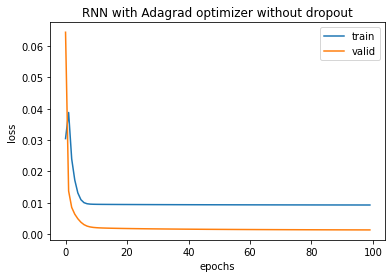

In [261]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('RNN with Adagrad optimizer without dropout')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


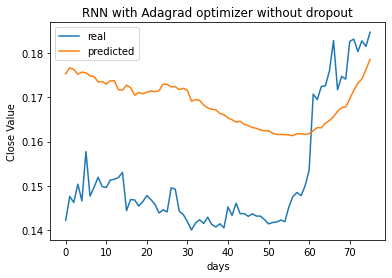

In [262]:
predicted = predict(rnn, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('RNN with Adagrad optimizer without dropout')
plt.legend()

In [267]:
%%time
lstm = WolfLSTM(50, 4, 5, 1, 100, cell_type=nn.LSTM, model_name='LSTM').cuda()
loss = nn.MSELoss() 
opt = optim.Adagrad(lstm.parameters(), lr=0.001)

losses, valid_losses = train(lstm, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.24869537353515625
============================== epoch 1, loss 0.007510542403906584
passed time: 0.2373487949371338
============================== epoch 2, loss 0.00011914967035409063
passed time: 0.18609976768493652
============================== epoch 3, loss 0.00010704096348490566
passed time: 0.2218465805053711
============================== epoch 4, loss 0.0003508634399622679
passed time: 0.2577035427093506
============================== epoch 5, loss 0.00048816739581525326
passed time: 0.17784404754638672
============================== epoch 6, loss 0.0006300336681306362
passed time: 0.2403886318206787
============================== epoch 7, loss 0.0007847856031730771
passed time: 0.19135689735412598
============================== epoch 8, loss 0.0009517527651041746
passed time: 0.22200703620910645
============================== epoch 9, loss 0.0008728642715141177
passed time: 0.2136523723602295
============================== epoch 10, loss 0.0009276274358853698
pa

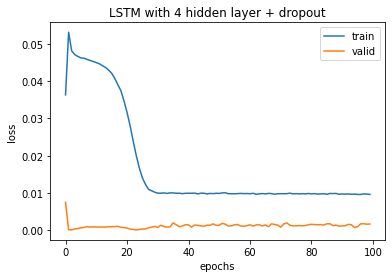

In [268]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LSTM with 4 hidden layer + dropout')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


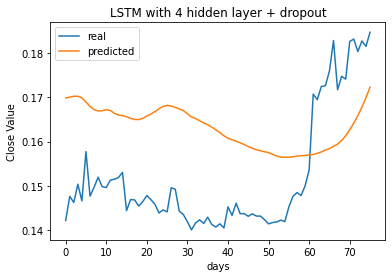

In [269]:
predicted = predict(lstm, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('LSTM with 4 hidden layer + dropout')
plt.legend()

In [272]:
%%time
lstm = WolfLSTM(50, 4, 5, 1, 100, cell_type=nn.LSTM, model_name='LSTM').cuda()
loss = nn.MSELoss() 
opt = optim.Adagrad(lstm.parameters(), lr=0.001)

losses, valid_losses = train(lstm, x_train, y_train, x_valid, y_valid, loss, opt)

============================== epoch 0, loss None
passed time: 0.10818719863891602
============================== epoch 1, loss 0.013592054136097431


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (tor

passed time: 0.10938835144042969
============================== epoch 2, loss 0.00044343146146275103
passed time: 0.10545229911804199
============================== epoch 3, loss 2.376774136791937e-05
passed time: 0.10338020324707031
============================== epoch 4, loss 9.184020746033639e-05
passed time: 0.10187673568725586
============================== epoch 5, loss 0.0001982942339964211
passed time: 0.10355377197265625
============================== epoch 6, loss 0.00029352522687986493
passed time: 0.10224771499633789
============================== epoch 7, loss 0.00037230399902909994
passed time: 0.10657072067260742
============================== epoch 8, loss 0.0004359773301985115
passed time: 0.10671043395996094
============================== epoch 9, loss 0.0004865301016252488
passed time: 0.10718774795532227
============================== epoch 10, loss 0.0005254766438156366
passed time: 0.10889792442321777
============================== epoch 11, loss 0.000553650839719

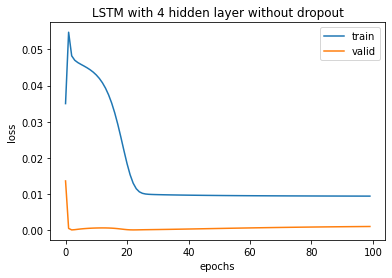

In [273]:
plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LSTM with 4 hidden layer without dropout')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


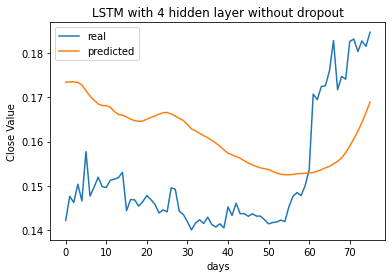

In [276]:
predicted = predict(lstm, x_test)
plt.plot(y_test, label='real')
plt.plot(predicted, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('LSTM with 4 hidden layer without dropout')
plt.legend()

In [318]:
seq = Sequential()

seq.add(ConvLSTM2D(filters=100, kernel_size=3,
                   input_shape=(seq_len, 1, 1, 5),
                   padding='same', return_sequences=True,
                   dropout=0.2, activation='relu'))
# seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=100, kernel_size=3,
                   padding='same', return_sequences=True, 
                   dropout=0.2, activation='relu'))

seq.add(Dense(50, activation='relu'))

seq.add(Dense(1, activation='sigmoid'))
seq.compile(loss='mse', optimizer='adam')
seq.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_28 (ConvLSTM2D) (None, 24, 1, 1, 100)     378400    
_________________________________________________________________
conv_lst_m2d_29 (ConvLSTM2D) (None, 24, 1, 1, 100)     720400    
_________________________________________________________________
dense_29 (Dense)             (None, 24, 1, 1, 50)      5050      
_________________________________________________________________
dense_30 (Dense)             (None, 24, 1, 1, 1)       51        
Total params: 1,103,901
Trainable params: 1,103,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train = x_train.detach().cpu().numpy()
y_train = y_train.detach().cpu().numpy()
x_valid = x_valid.detach().cpu().numpy()
y_valid = y_valid.detach().cpu().numpy()
x_train = x_train.reshape((len(x_train), 24, 1, 1, 5))
x_valid = x_valid.reshape((len(x_valid), 24, 1, 1, 5))

In [319]:
history = seq.fit(x=x_train, y=y_train, batch_size=64, epochs=50, validation_data=(x_valid, y_valid))

Epoch 1/50
33/33 [==============================] - 20s 313ms/step - loss: 0.1643 - val_loss: 0.0266
Epoch 2/50
33/33 [==============================] - 9s 273ms/step - loss: 0.0393 - val_loss: 0.0257
Epoch 3/50
33/33 [==============================] - 9s 271ms/step - loss: 0.0347 - val_loss: 0.0255
Epoch 4/50
33/33 [==============================] - 9s 275ms/step - loss: 0.0388 - val_loss: 0.0254
Epoch 5/50
33/33 [==============================] - 9s 276ms/step - loss: 0.0374 - val_loss: 0.0255
Epoch 6/50
33/33 [==============================] - 9s 279ms/step - loss: 0.0326 - val_loss: 0.0256
Epoch 7/50
33/33 [==============================] - 9s 278ms/step - loss: 0.0357 - val_loss: 0.0257
Epoch 8/50
33/33 [==============================] - 9s 281ms/step - loss: 0.0347 - val_loss: 0.0258
Epoch 9/50
33/33 [==============================] - 9s 280ms/step - loss: 0.0336 - val_loss: 0.0259
Epoch 10/50
33/33 [==============================] - 10s 290ms/step - loss: 0.0287 - val_loss: 0.02

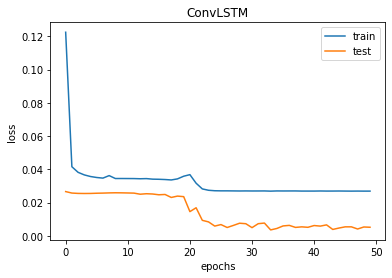

In [320]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ConvLSTM')
plt.legend()

torch.Size([76, 1])


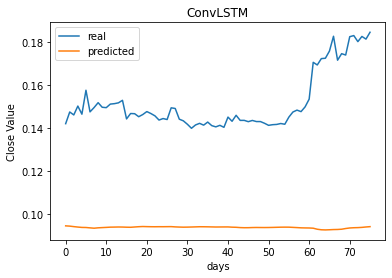

In [321]:
# x_test = x_test.detach().cpu().numpy().reshape((len(x_test), 24, 1, 1, 5))
pred = seq.predict(x_test)
pred = [p[-1][0][0] for p in pred]
# print(pred.shape)
print(y_test.shape)
plt.plot(y_test, label='real')
plt.plot(pred, label='predicted')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.title('ConvLSTM')
plt.legend()

In [329]:
yy_train = y_train
yy_valid = y_valid
yy_test = y_test
xx_train = x_train
xx_valid = x_valid
xx_test = x_test

In [330]:
xxx_train = xx_train.reshape(2103,120)
xxx_valid = xx_valid.reshape(16,120)
xxx_test = xx_test.reshape(76,120)

In [331]:
# univariate mlp example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
# define model
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=120))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
trained_model = model.fit(xxx_train, yy_train,validation_data=(xxx_valid,yy_valid), epochs=200, verbose=1)


Epoch 1/200
66/66 [==============================] - 1s 6ms/step - loss: 0.0081 - val_loss: 0.0019
Epoch 2/200
66/66 [==============================] - 0s 2ms/step - loss: 5.2698e-04 - val_loss: 1.0491e-04
Epoch 3/200
66/66 [==============================] - 0s 2ms/step - loss: 3.5225e-04 - val_loss: 1.0446e-04
Epoch 4/200
66/66 [==============================] - 0s 2ms/step - loss: 2.7034e-04 - val_loss: 2.3599e-04
Epoch 5/200
66/66 [==============================] - 0s 2ms/step - loss: 9.4206e-04 - val_loss: 1.0311e-04
Epoch 6/200
66/66 [==============================] - 0s 2ms/step - loss: 3.9778e-04 - val_loss: 2.1188e-04
Epoch 7/200
66/66 [==============================] - 0s 2ms/step - loss: 2.6268e-04 - val_loss: 9.3296e-05
Epoch 8/200
66/66 [==============================] - 0s 2ms/step - loss: 2.3768e-04 - val_loss: 4.0425e-04
Epoch 9/200
66/66 [==============================] - 0s 2ms/step - loss: 2.1523e-04 - val_loss: 1.1830e-04
Epoch 10/200
66/66 [=========================

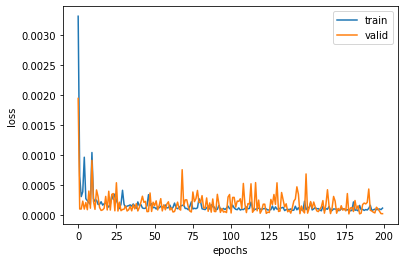

In [332]:
#test_loss,test_acc = model.evaluate(xxx_test, yy_test , batch_size=1)

history=trained_model.history

losses=history['loss']
val_losses=history['val_loss']
#ac=history['MAE']
#val_ac=history['val_MAE']

plt.plot(losses,label = 'train')
plt.plot(val_losses,label = 'valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


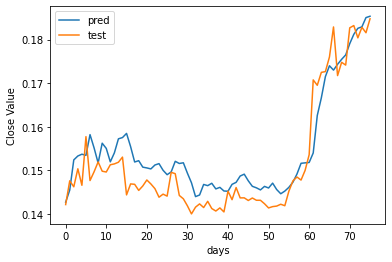

In [333]:
predict = model.predict(xxx_test)
 
plt.plot(predict,label = 'pred')
plt.plot(yy_test,label='test')
plt.xlabel('days')
plt.ylabel('Close Value')
plt.legend()

In [ ]:
from copy import deepcopy
def pure_predict(model, x_test):
    
    xx = deepcopy(x_test)
    xx = tensor(xx).float().cuda()
    model.eval()
    predicted = []
    hidden = model.init_hidden(1)

    pred, hidden = model(xx[0].reshape(1, xx.shape[1], xx.shape[2]), hidden, eval_=True)
    predicted.append(pred.detach().cpu().numpy()[0])

    for i in range(7):
        xx = xx.detach().cpu().numpy()
        xx[i+1][-1][0] = predicted[-1]
        xx = tensor(xx).float().cuda()
        pred, hidden = model(xx[i+1].reshape(1, xx.shape[1], xx.shape[2]), hidden, eval_=True)
        predicted.append(pred.detach().cpu().numpy()[0])

    return predicted

In [ ]:
%%time
lstm = WolfLSTM(50, 4, 5, 1, 100, cell_type=nn.LSTM, model_name='LSTM').cuda()
loss = nn.MSELoss() 
opt = optim.Adagrad(lstm.parameters(), lr=0.001)

losses, valid_losses = train(lstm, x_train, y_train, x_valid, y_valid, loss, opt)

In [ ]:
pred = pure_predict(lstm, x_test)
plt.plot(y_test[:8], label='real')
plt.plot(pred, label='predicted')
plt.xlabel('days')
plt.ylabel('Close value')
plt.legend()